In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pins-face-recognition/105_classes_pins_dataset/pins_Alex Lawther/Alex Lawther233_93.jpg
/kaggle/input/pins-face-recognition/105_classes_pins_dataset/pins_Alex Lawther/Alex Lawther37_110.jpg
/kaggle/input/pins-face-recognition/105_classes_pins_dataset/pins_Alex Lawther/Alex Lawther228_91.jpg
/kaggle/input/pins-face-recognition/105_classes_pins_dataset/pins_Alex Lawther/Alex Lawther92_145.jpg
/kaggle/input/pins-face-recognition/105_classes_pins_dataset/pins_Alex Lawther/Alex Lawther40_113.jpg
/kaggle/input/pins-face-recognition/105_classes_pins_dataset/pins_Alex Lawther/Alex Lawther196_69.jpg
/kaggle/input/pins-face-recognition/105_classes_pins_dataset/pins_Alex Lawther/Alex Lawther159_45.jpg
/kaggle/input/pins-face-recognition/105_classes_pins_dataset/pins_Alex Lawther/Alex Lawther129_24.jpg
/kaggle/input/pins-face-recognition/105_classes_pins_dataset/pins_Alex Lawther/Alex Lawther182_63.jpg
/kaggle/input/pins-face-recognition/105_classes_pins_dataset/pins_Alex Lawther/Ale

In [12]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121  # You can choose DenseNet121, 169, or 201

In [13]:
# Preprocess the images
def preprocess_image(image_path):
    try:
        image = cv2.imread(image_path)
        if image is None:
            corrupted_images.append(image_path)
            return None
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (128, 128))  # Xception input size
        return image
    except Exception:
        corrupted_images.append(image_path)
        return None

In [14]:
# Load the dataset
def load_artist_data_as_dataframe(data_dir):
    data = []  
    label_map = {}
    corrupted_images = []

    for idx, folder in enumerate(os.listdir(data_dir)):
        if folder.startswith("pins_"):
            artist_name = folder.split('_', 1)[1]
            folder_path = os.path.join(data_dir, folder)
            num_images = len([file for file in os.listdir(folder_path) if file.endswith(('.jpg', '.jpeg', '.png'))])
            label_map[artist_name] = (idx, num_images)

    # Sort the label_map by the number of images and select the biggest 55 classes
    sorted_label_map = dict(sorted(label_map.items(), key=lambda item: item[1][1], reverse=True)[:55])

    # Remap the labels to be in the range 0 to 54
    new_label_map = {artist_name: new_idx for new_idx, (artist_name, _) in enumerate(sorted_label_map.items())}

    for artist_name, (old_idx, _) in sorted_label_map.items():
        folder = f"pins_{artist_name}"
        folder_path = os.path.join(data_dir, folder)
        
        for file in os.listdir(folder_path):
            if file.endswith(('.jpg', '.jpeg', '.png')):
                file_path = os.path.join(folder_path, file)
                image = preprocess_image(file_path)
                if image is not None:
                    data.append({
                        "image_array": image,
                        "image_path": file_path,
                        "label": new_label_map[artist_name],
                        "artist_name": artist_name
                    })
    
    df = pd.DataFrame(data)
    return df, new_label_map

In [15]:
data_dir = "/kaggle/input/pins-face-recognition/105_classes_pins_dataset" 
df, label_map = load_artist_data_as_dataframe(data_dir)

In [17]:
from tensorflow.keras.applications.xception import preprocess_input

In [18]:
# Train-test split
df = df.groupby('label').filter(lambda x: len(x) >= 2)
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

X_train = np.stack(train_df['image_array'].values)
y_train = train_df['label'].values

X_test = np.stack(test_df['image_array'].values)
y_test = test_df['label'].values

# Normalize for Xception
X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [19]:
import os
import cv2
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras import Sequential
#from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import DenseNet121  # You can choose DenseNet121, 169, or 201

In [20]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the base model's layers
for layer in base_model.layers:
    layer.trainable = False

# Custom classification layers on top of Xception
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)  # Adjust the number of units if needed
x = Dropout(0.5)(x)
output_layer = Dense(len(np.unique(y_train)), activation='softmax')(x)

# Combine base model and new layers
model = Model(inputs=base_model.input, outputs=output_layer)

model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# Print the model summary
model.summary()

# Training with data augmentation
train_generator = datagen.flow(X_train, y_train, batch_size=32)
val_generator = datagen.flow(X_test, y_test, batch_size=32)


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 134, 134,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 32, 32,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 32, 32,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 32, 32,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 32, 32,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 32, 32,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 32, 32,    │     12,288 │ conv2_block2_0_r

 Total params: 7,590,519 (28.96 MB)

 Trainable params: 553,015 (2.11 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [21]:
# Train the model
history = model.fit(
    train_generator,
    epochs=150,
    validation_data=val_generator
)

Epoch 1/150


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1734535233.212185      75 service.cc:145] XLA service 0x7d4700002f00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734535233.212269      75 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1734535233.212275      75 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  2/267 ━━━━━━━━━━━━━━━━━━━━ 13s 51ms/step - accuracy: 0.0391 - loss: 5.4966   

I0000 00:00:1734535245.578201      75 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


267/267 ━━━━━━━━━━━━━━━━━━━━ 88s 236ms/step - accuracy: 0.0224 - loss: 4.6472 - val_accuracy: 0.0690 - val_loss: 3.7812
Epoch 2/150
267/267 ━━━━━━━━━━━━━━━━━━━━ 40s 145ms/step - accuracy: 0.0470 - loss: 3.8715 - val_accuracy: 0.0911 - val_loss: 3.6288
Epoch 3/150
267/267 ━━━━━━━━━━━━━━━━━━━━ 39s 145ms/step - accuracy: 0.0680 - loss: 3.6847 - val_accuracy: 0.1244 - val_loss: 3.4823
Epoch 4/150
267/267 ━━━━━━━━━━━━━━━━━━━━ 39s 145ms/step - accuracy: 0.0827 - loss: 3.5841 - val_accuracy: 0.1319 - val_loss: 3.3818
Epoch 5/150
267/267 ━━━━━━━━━━━━━━━━━━━━ 39s 145ms/step - accuracy: 0.1093 - loss: 3.4589 - val_accuracy: 0.1399 - val_loss: 3.2902
Epoch 6/150
267/267 ━━━━━━━━━━━━━━━━━━━━ 40s 146ms/step - accuracy: 0.1180 - loss: 3.3772 - val_accuracy: 0.1587 - val_loss: 3.2228
Epoch 7/150
267/267 ━━━━━━━━━━━━━━━━━━━━ 40s 145ms/step - accuracy: 0.1334 - loss: 3.3137 - val_accuracy: 0.1869 - val_loss: 3.1422
Epoch 8/150
267/267 ━━━━━━━━━━━━━━━━━━━━ 40s 146ms/step - accuracy: 0.1422 - loss: 3.235

In [38]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Loss: {test_loss}, Accuracy: {test_accuracy * 100}%")

67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.4054 - loss: 2.1552
Loss: 2.174546003341675, Accuracy: 40.70422649383545%


In [39]:
train_loss12, train_accuracy12 = model.evaluate(X_train, y_train)
print(f"Loss: {train_loss12}, Accuracy: {train_accuracy12 * 100}%")

267/267 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.5911 - loss: 1.4834
Loss: 1.4839818477630615, Accuracy: 58.72066020965576%


In [29]:
model.save('/kaggle/working/dens_face_55classification_taufik.h5')

In [30]:
import os
os.listdir('/kaggle/working/')


['.virtual_documents',
 'dens_face_55classification_taufik.keras',
 'dens_face_55classification_taufik.h5']

In [31]:
from IPython.display import FileLink
FileLink('/kaggle/working/dens_face_55classification_taufik.h5')

/kaggle/working/dens_face_55classification_taufik.h5

In [32]:
model_file = "dens_face_55classification_taufik.h5" 
model.save(model_file) # Create a link to download the file 
FileLink(r'dens_face_55classification_taufik.h5')

/kaggle/working/dens_face_55classification_taufik.h5

In [33]:
model_file = "dens_face_55classification_taufik.keras" 
model.save(model_file) # Create a link to download the file 
FileLink(r'dens_face_55classification_taufik.keras')

/kaggle/working/dens_face_55classification_taufik.keras

In [35]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt

67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step
Accuracy: 0.4070422535211268


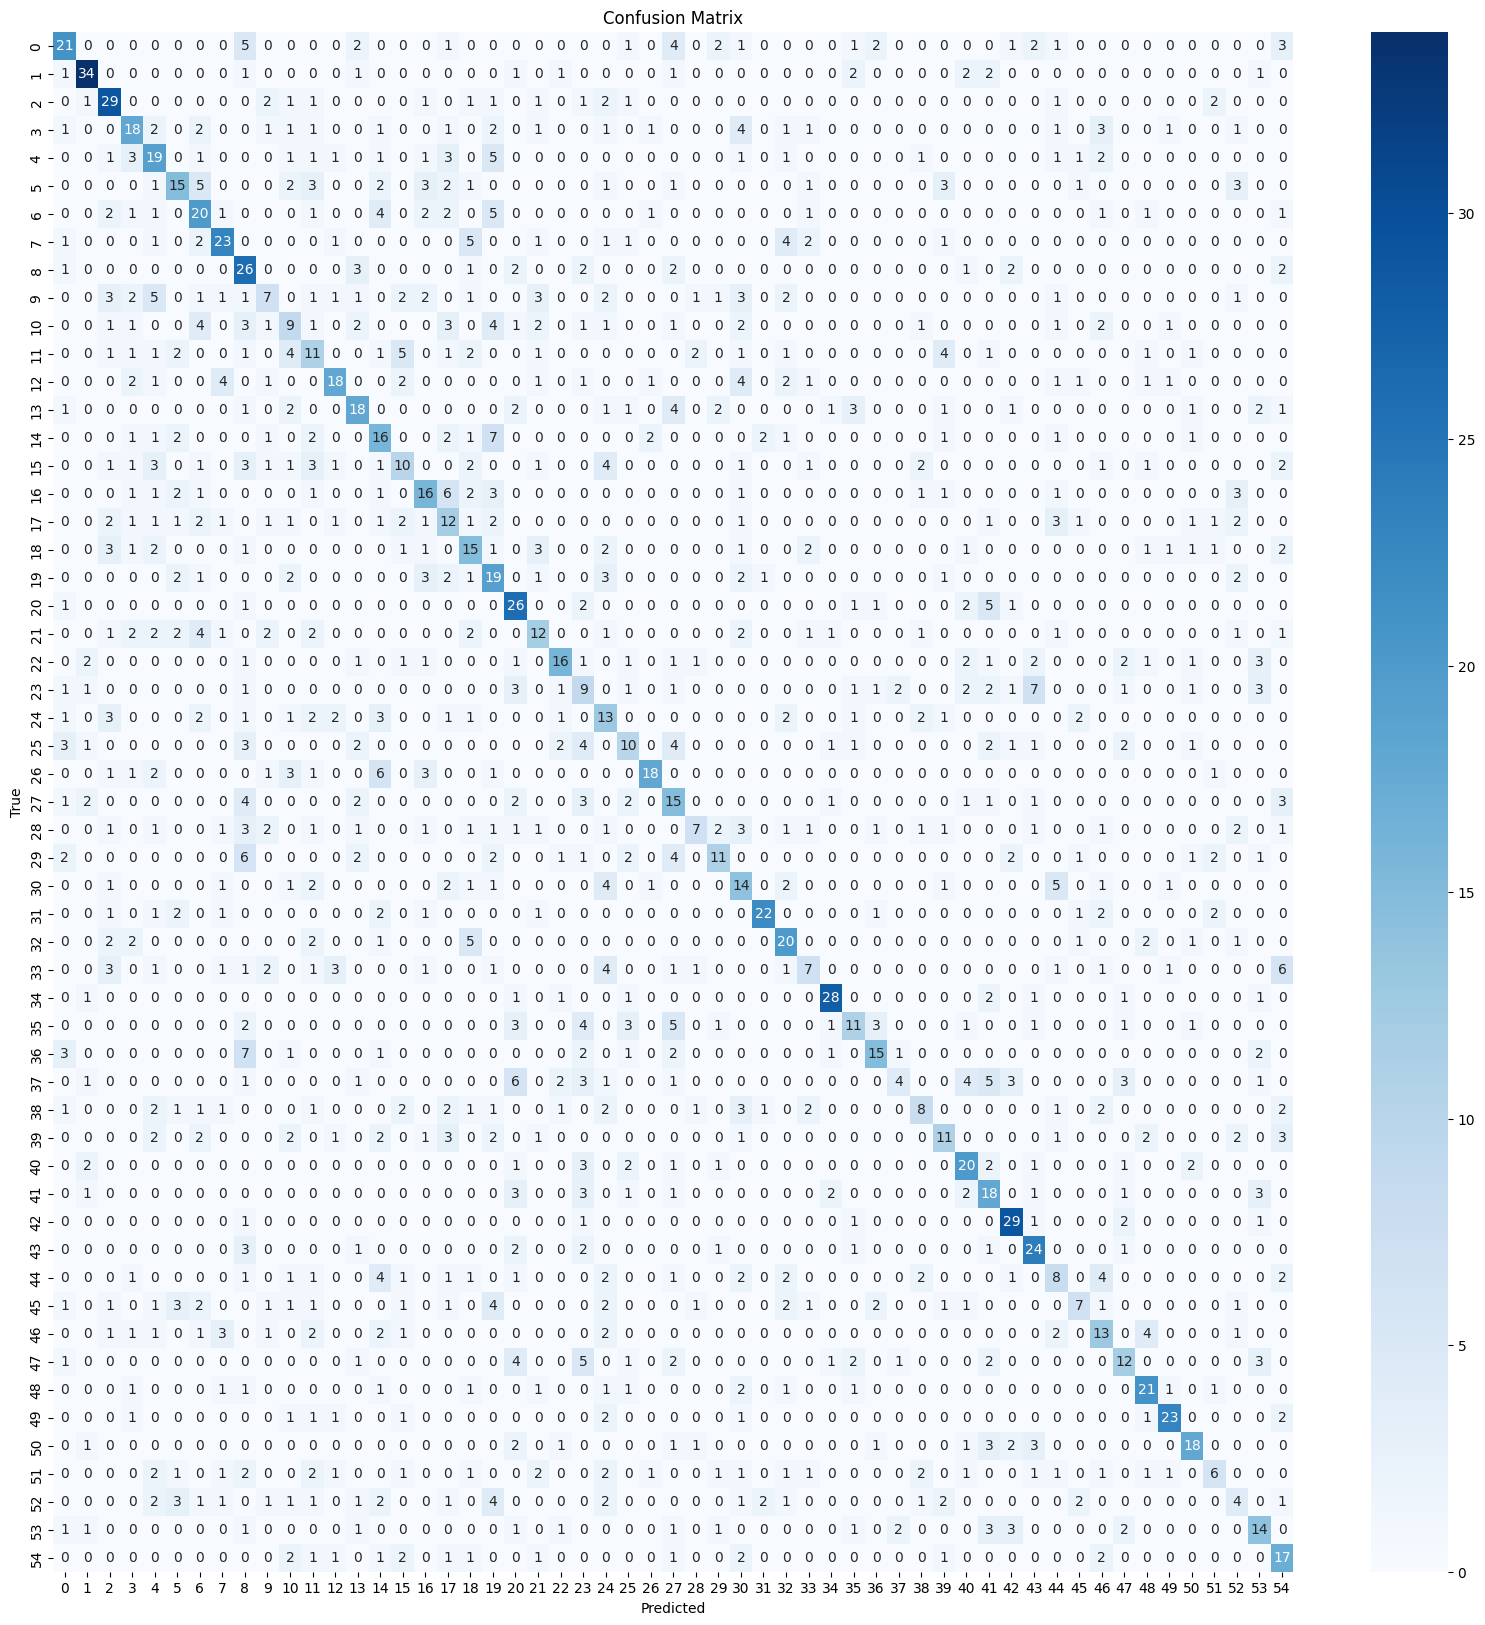

In [42]:
from sklearn.metrics import accuracy_score

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

accuracy = accuracy_score(y_test, y_pred_classes)
print("Accuracy:", accuracy)

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

              precision    recall  f1-score   support

           0       0.50      0.45      0.47        47
           1       0.71      0.72      0.72        47
           2       0.50      0.64      0.56        45
           3       0.43      0.40      0.41        45
           4       0.34      0.43      0.38        44
           5       0.42      0.34      0.37        44
           6       0.38      0.45      0.41        44
           7       0.55      0.53      0.54        43
           8       0.32      0.62      0.42        42
           9       0.28      0.17      0.21        42
          10       0.24      0.21      0.23        42
          11       0.23      0.26      0.25        42
          12       0.56      0.43      0.49        42
          13       0.45      0.43      0.44        42
          14       0.30      0.39      0.34        41
          15       0.31      0.24      0.27        41
          16       0.42      0.39      0.41        41
          17       0.26    

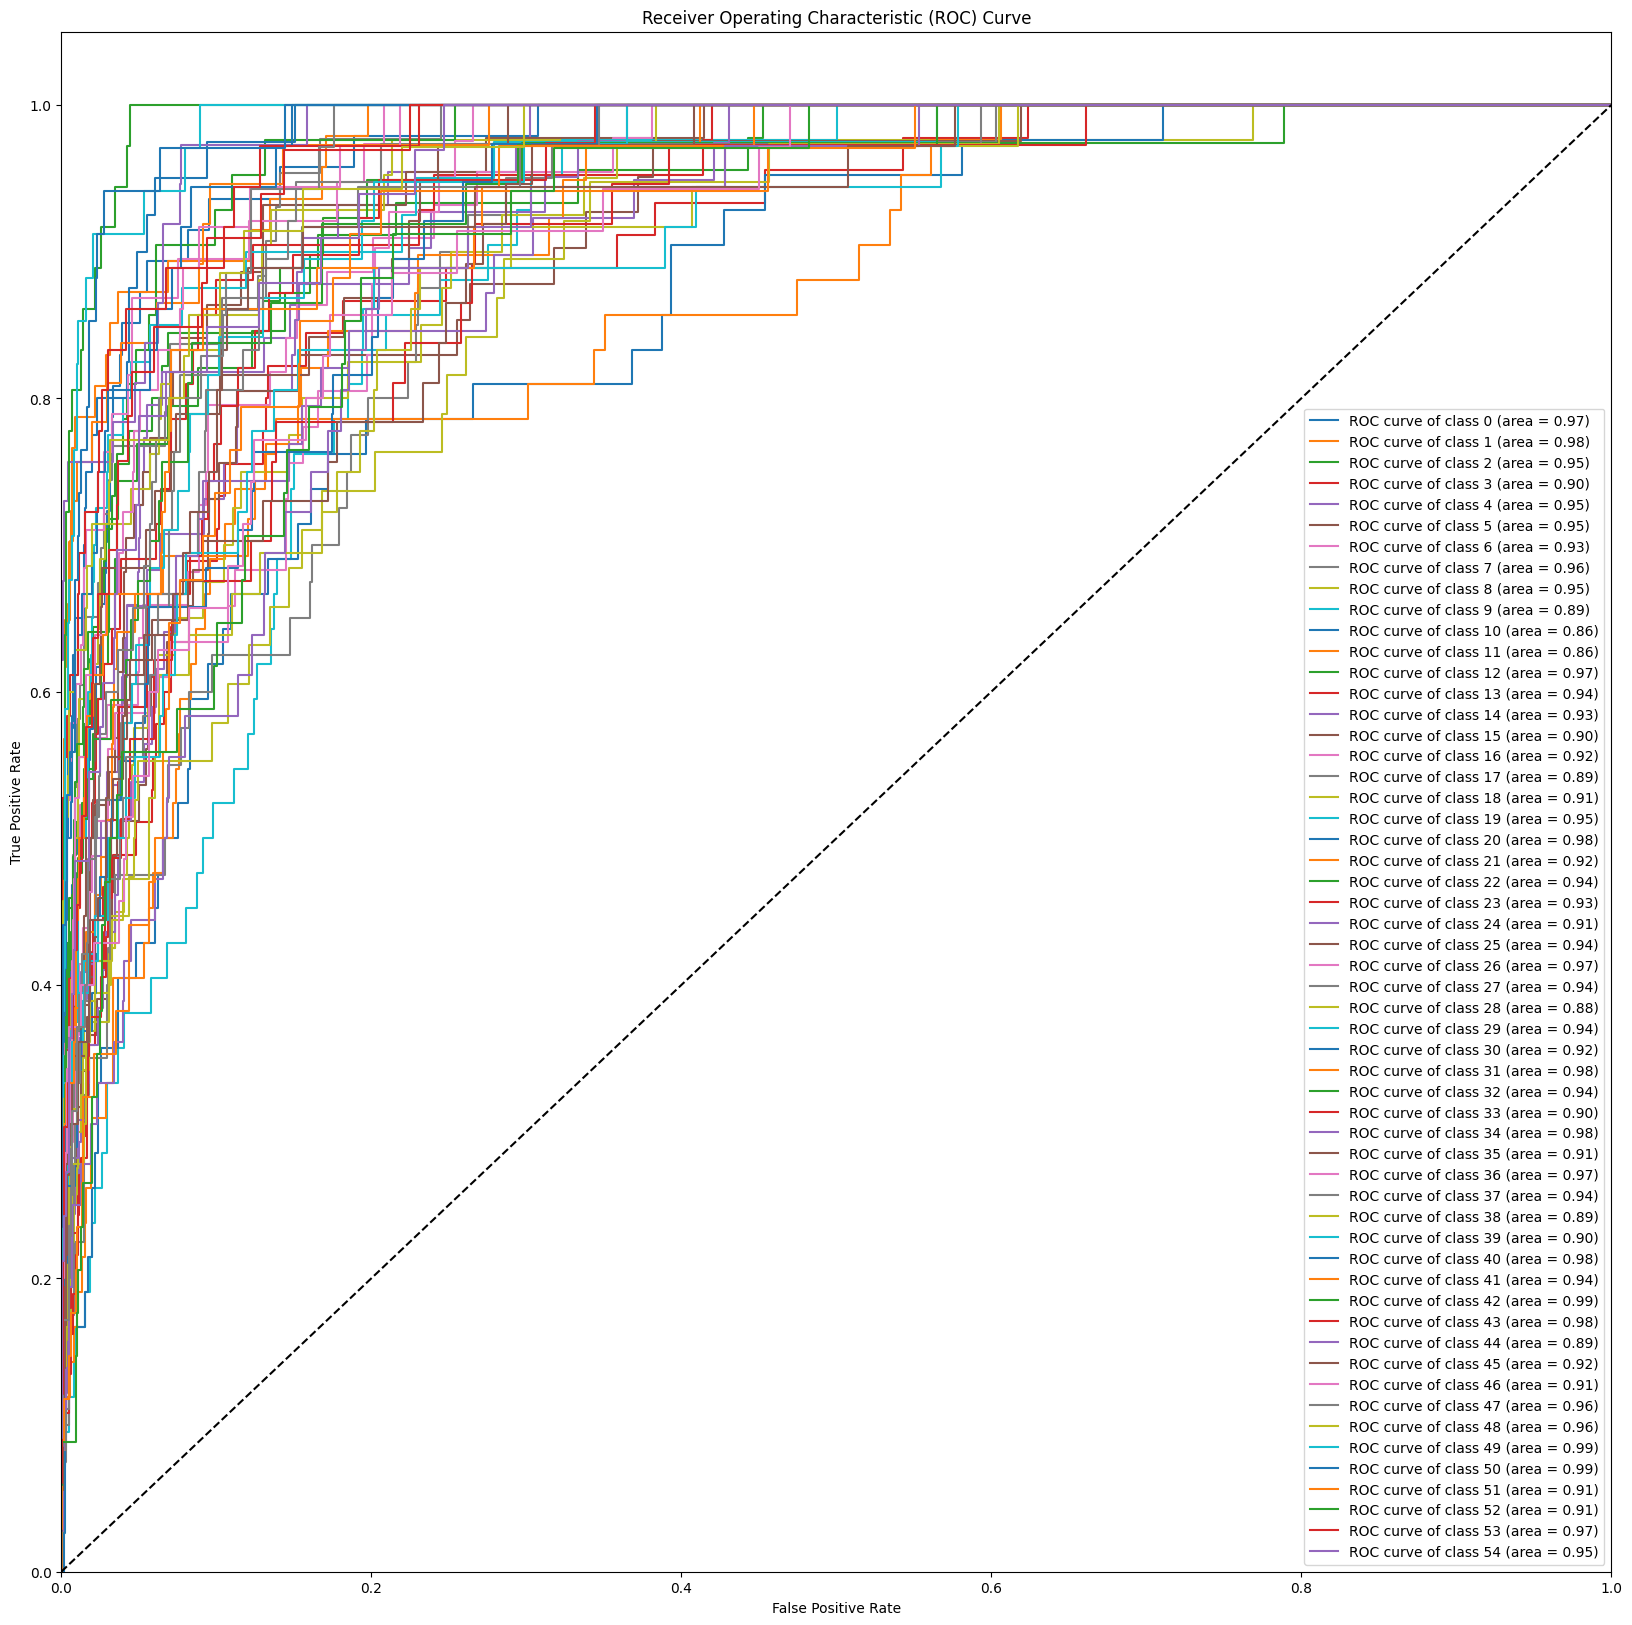

In [43]:

from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred_classes)
print(report)
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Assuming multi-class classification
y_test_one_hot = label_binarize(y_test, classes=np.unique(y_test))

# Get class probabilities
y_pred_prob = model.predict(X_test)  # Assuming softmax output layer
# Or, if necessary:
# y_pred_prob = softmax(model.predict(X_test), axis=1)

# Calculate ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test_one_hot.shape[1]
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_one_hot[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(20, 20))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

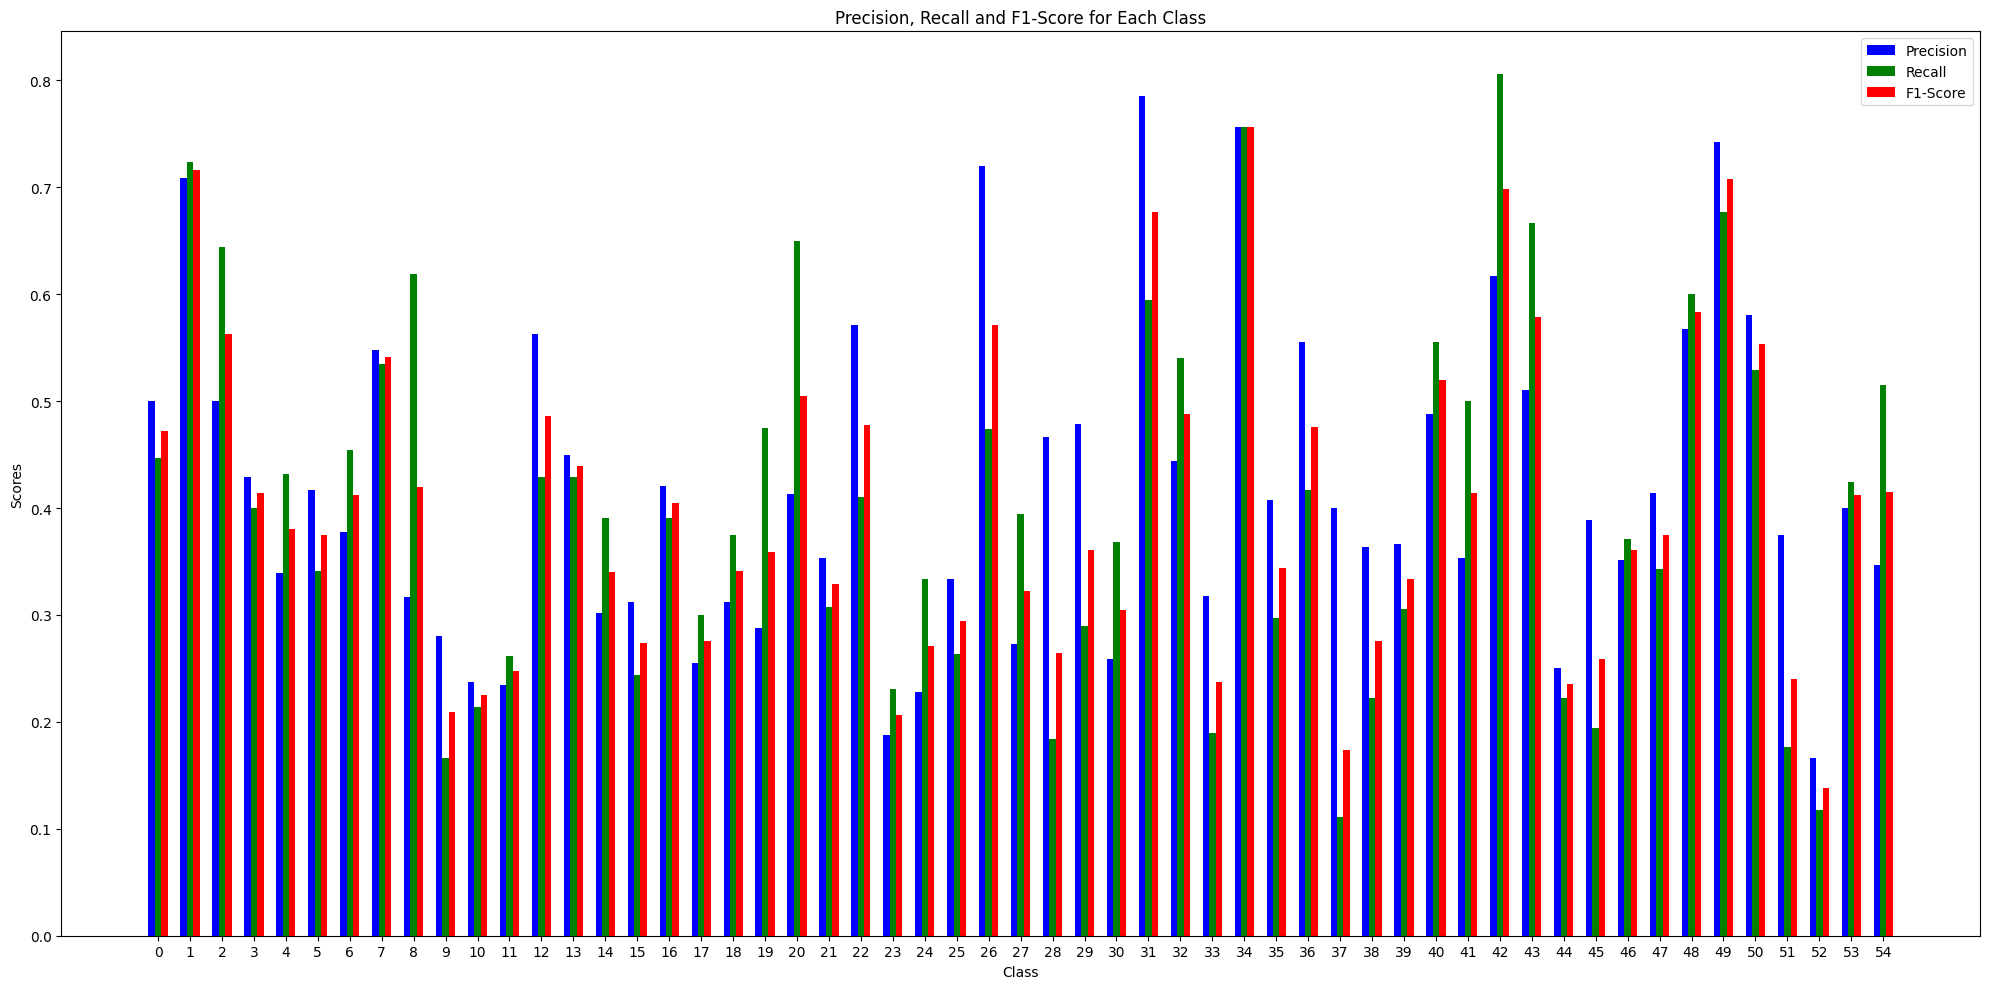

In [45]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import numpy as np

# Assuming y_test are true labels and y_pred_classes are predicted labels
report = classification_report(y_test, y_pred_classes, output_dict=True)

# Extracting metrics for each class
classes = list(report.keys())[:-3]  # Exclude accuracy, macro avg, and weighted avg
precision = [report[class_name]['precision'] for class_name in classes]
recall = [report[class_name]['recall'] for class_name in classes]
f1_score = [report[class_name]['f1-score'] for class_name in classes]

# Plotting the metrics
x = np.arange(len(classes))

fig, ax = plt.subplots(figsize=(20, 10))
width = 0.2  # Bar width
ax.bar(x - width, precision, width, label='Precision', color='b')
ax.bar(x, recall, width, label='Recall', color='g')
ax.bar(x + width, f1_score, width, label='F1-Score', color='r')

# Adding labels and title
ax.set_xlabel('Class')
ax.set_ylabel('Scores')
ax.set_title('Precision, Recall and F1-Score for Each Class')
ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.legend()

plt.tight_layout()
plt.show()

In [46]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

# Assuming multi-class classification
y_test_one_hot = label_binarize(y_test, classes=np.unique(y_test))

fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test_one_hot.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_one_hot[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Print AUC values
print("AUC values for each class:")
for i in range(n_classes):
    print(f"Class {i}: {roc_auc[i]:.2f}")

AUC values for each class:
Class 0: 0.97
Class 1: 0.98
Class 2: 0.95
Class 3: 0.90
Class 4: 0.95
Class 5: 0.95
Class 6: 0.93
Class 7: 0.96
Class 8: 0.95
Class 9: 0.89
Class 10: 0.86
Class 11: 0.86
Class 12: 0.97
Class 13: 0.94
Class 14: 0.93
Class 15: 0.90
Class 16: 0.92
Class 17: 0.89
Class 18: 0.91
Class 19: 0.95
Class 20: 0.98
Class 21: 0.92
Class 22: 0.94
Class 23: 0.93
Class 24: 0.91
Class 25: 0.94
Class 26: 0.97
Class 27: 0.94
Class 28: 0.88
Class 29: 0.94
Class 30: 0.92
Class 31: 0.98
Class 32: 0.94
Class 33: 0.90
Class 34: 0.98
Class 35: 0.91
Class 36: 0.97
Class 37: 0.94
Class 38: 0.89
Class 39: 0.90
Class 40: 0.98
Class 41: 0.94
Class 42: 0.99
Class 43: 0.98
Class 44: 0.89
Class 45: 0.92
Class 46: 0.91
Class 47: 0.96
Class 48: 0.96
Class 49: 0.99
Class 50: 0.99
Class 51: 0.91
Class 52: 0.91
Class 53: 0.97
Class 54: 0.95


67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step


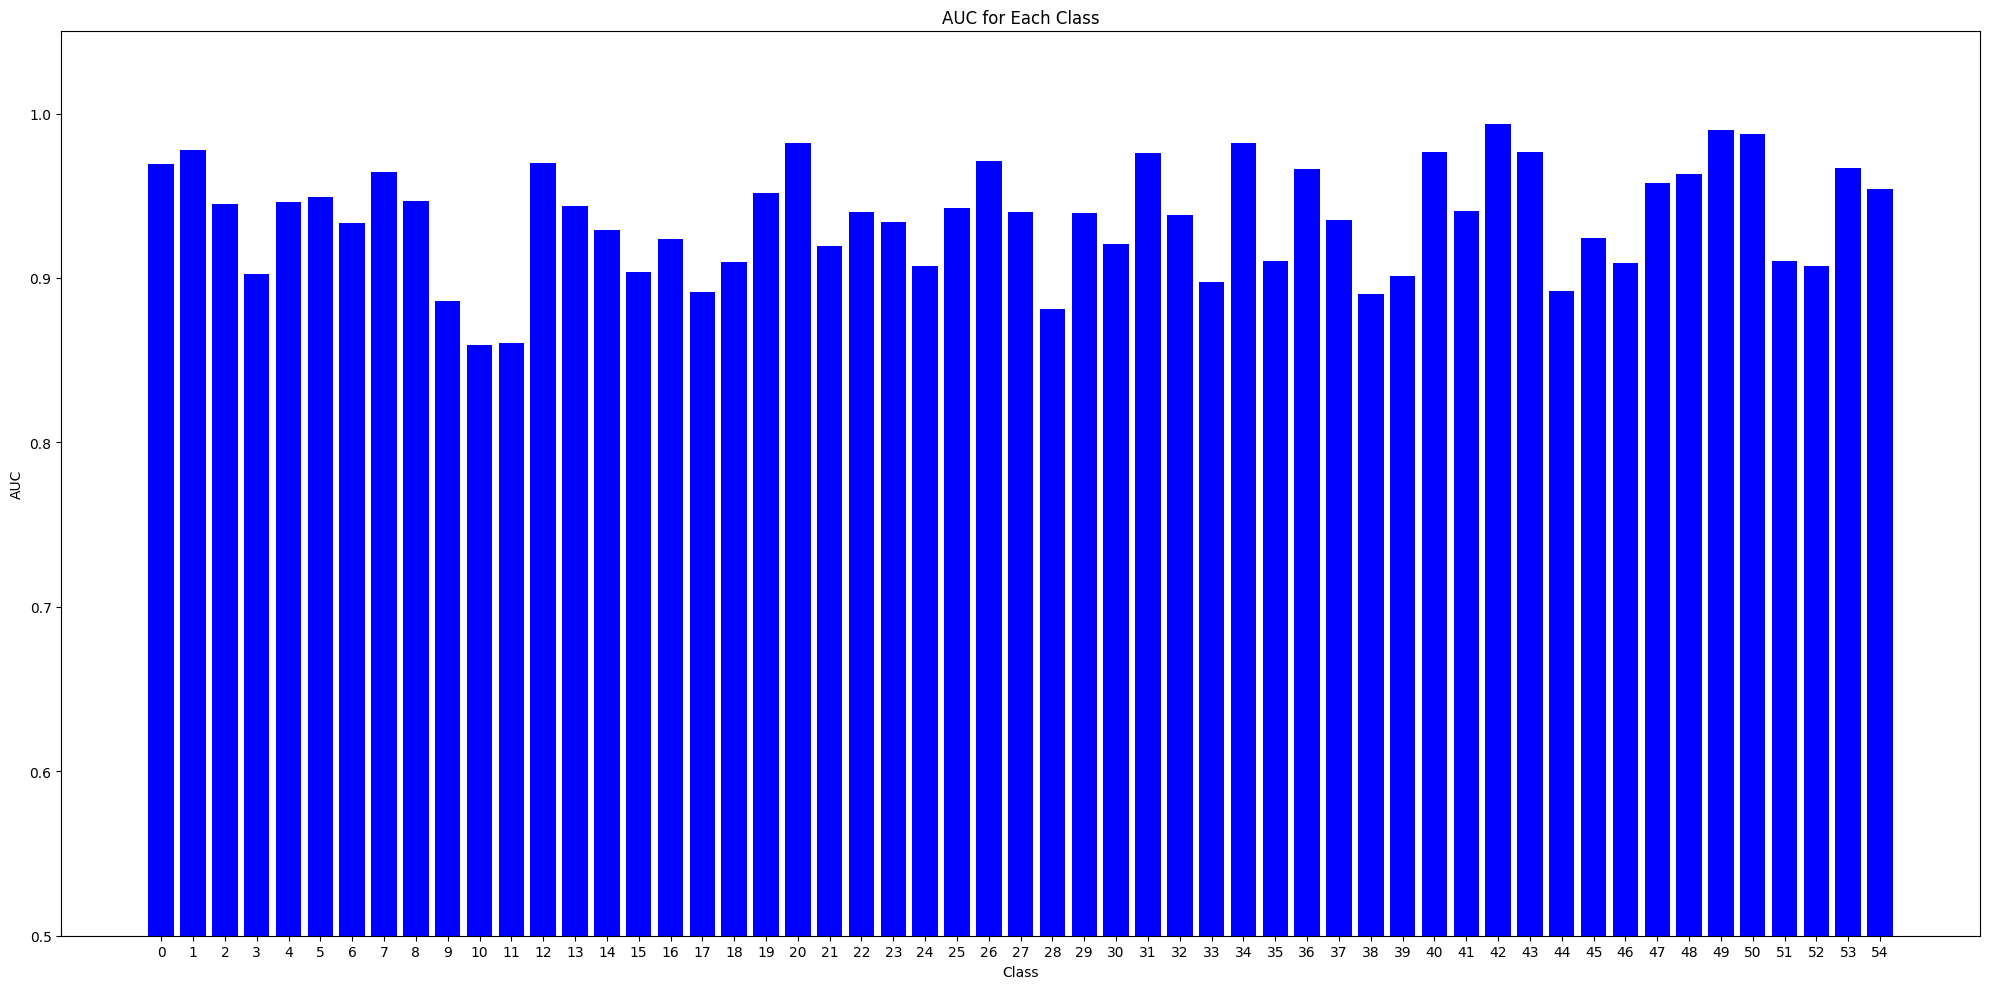

In [51]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

# Assuming multi-class classification
y_test_one_hot = label_binarize(y_test, classes=np.unique(y_test))
y_pred_prob = model.predict(X_test)  # Assuming softmax output layer

fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test_one_hot.shape[1]

# Calculate ROC curve and AUC for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_one_hot[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot AUC values for each class as a bar chart
classes = [f"{i}" for i in range(n_classes)]
auc_values = [roc_auc[i] for i in range(n_classes)]

# Plotting the AUC values as a bar chart
plt.figure(figsize=(20, 10))
plt.bar(classes, auc_values, color='blue')
plt.xlabel('Class')
plt.ylabel('AUC')
plt.title('AUC for Each Class')
plt.ylim([0.5, 1.05])  # AUC ranges from 0.5 to 1
plt.tight_layout()
plt.show()
